<a href="https://colab.research.google.com/github/NeemaNdanu/Natural-language-processing/blob/main/Final_Project_on_Arabic_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**4. Text Classification in African Languages**

**o Objective:** Develop a model to classify text documents in an African language (e.g., news articles, social media posts) by topic (e.g., sports, politics, entertainment).

**o Tasks:**Use or collect a labeled dataset, preprocess it, and train a classification model.

**o Expected Outcome:** A classifier that can categorize texts into predefined topics with a reasonable accuracy.

The dataset consists of 111,728 documents (cf. Table 1) and 319,254,124 words (cf. Table 2) structured in text files, and collected from 3 Arabic online newspapers: Assabah [9], Hespress [10] and Akhbarona [11] using semi-automatic web crawling process.

The documents in the dataset are categorized into 5 classes: sport, politic, culture, economy and diverse. The number of documents and words for each class varies from one class to another (cf. Tables 1-2)

**DEVICE CONFIGURATION**

In [ ]:
import torch
from torch import cuda
print(torch.cuda.is_available())
device = 'cuda' if cuda.is_available() else 'cpu'

True


In [ ]:
!pip install -q transformers

In [ ]:
!pip install transformers

In [ ]:
# Load the necessary libraries
import pandas as pd
import warnings
from tqdm import tqdm
import numpy as np
from sklearn import metrics
import transformers
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import re
from transformers import AutoModelForSequenceClassification
import nltk
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import AutoTokenizer, AutoModel
from transformers import AdamW
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig


tqdm.pandas()
warnings.filterwarnings("ignore")

**DATA LOADING AND PREPROCESSING**

In [ ]:
# Load the data
df = pd.read_csv("/content/arabic_dataset_classifiction.csv", encoding='cp1256')
df.head()

,text,targe
0,ط¨ظٹظ† ط£ط³طھظˆط¯ظٹظˆظ‡ط§طھ ظˆط±ط²ط§ط²ط§طھ ظˆط...,0
1,ظ‚ط±ط±طھ ط§ظ„ظ†ط¬ظ…ط© ط§ظ„ط£ظ…ط±ظٹظƒظٹط© ط£ظˆط...,0
2,ط£ط®ط¨ط§ط±ظ†ط§ ط§ظ„ظ…ط؛ط±ط¨ظٹط© ط§ظ„ظˆط²ط§ظ†ظٹ...,0
3,ط§ط®ط¨ط§ط±ظ†ط§ ط§ظ„ظ…ط؛ط±ط¨ظٹط© ظ‚ط§ظ„ ط§ط¨ط±ط...,0
4,طھط²ط§ظ„ طµظ†ط§ط¹ط© ط§ظ„ط¬ظ„ظˆط¯ ظپظٹ ط§ظ„ظ…ط؛...,0


In [ ]:
print(df['targe'].value_counts())
print("Unique classes:", df['targe'].unique())


targe
4    46522
3    20505
1    16728
2    14235
0    13738
Name: count, dtype: int64
Unique classes: [0 1 2 3 4]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111728 entries, 0 to 111727
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    108789 non-null  object
 1   targe   111728 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


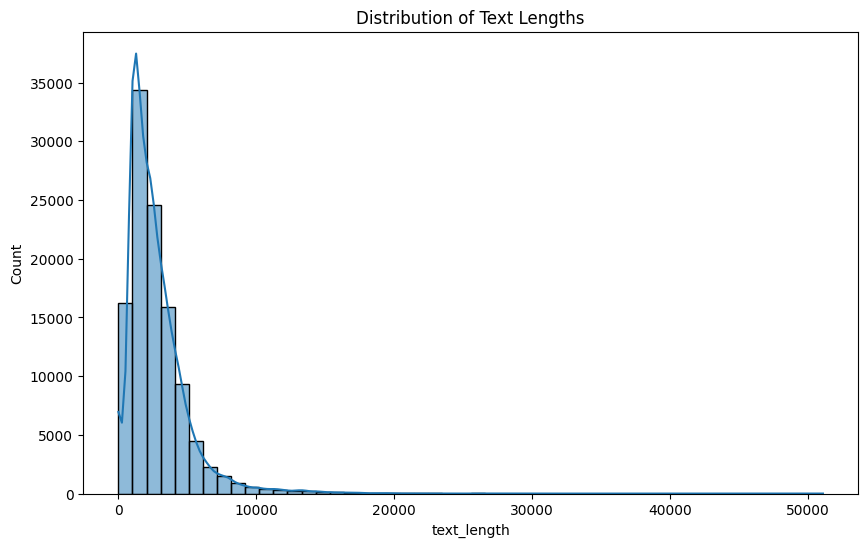

In [ ]:
# Basic statistics and information about the dataset
df.info()
df.describe()

# Handle missing values by filling NaNs with an empty string
df['text'] = df['text'].fillna('')

# Plot the distribution of text lengths
df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.show()

In [ ]:
df.shape

(111728, 3)

In [ ]:
# Download stopwords if not already downloaded
nltk.download('stopwords')
arabic_stopwords = set(stopwords.words('arabic'))

def preprocess_text(text):
    text = re.sub(r'\d+|\W+', ' ', text)
    text = ' '.join([word for word in text.split() if word not in arabic_stopwords])
    return text

def remove_punctuations(text):
    arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
    english_punctuations = string.punctuation
    punctuations_list = arabic_punctuations + english_punctuations
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

def preprocess_text(text):
    # Basic cleaning
    text = re.sub(r'\d+|\W+', ' ', text)
    # Remove punctuations
    text = remove_punctuations(text)
    # Normalize text
    text = normalize_arabic(text)
    # Remove repeating characters
    text = remove_repeating_char(text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in arabic_stopwords])
    return text


# Apply preprocessing
df['text'] = df['text'].apply(preprocess_text)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,targe,text_length
0,ظٹظ ط³طھظˆط ظٹظˆظ طھ ظˆط ط²ط ط²ط طھ ظˆطµط ط²ظˆ...,0,3440
1,طھ ظٹظƒظٹط ظˆط ظˆظٹظ ظپط ظٹ ظٹظ طھطµط ط¹ظ ط¹ظ ...,0,850
2,ظٹط ظˆط²ط ظٹ طھطµظˆظٹط ظٹ ظٹ ظˆط²ظٹ ط³ ط²ظٹط ظ...,0,1719
3,ظٹط ظٹظ ظٹ ظٹ ط³ط¹ط ظˆظƒظ ظٹط ظƒظ ظٹظ طµط ظپ ط...,0,2020
4,طھط²ط طµظ ط¹ط ظˆط ظپظٹ طھطھط ط¹ ظٹظ طھظ ظٹط ظٹ...,0,2613


**DATA PREPARATION**

In [ ]:
# Converts categorical labels into one-hot encoded vectors
df["list"] = df.targe.apply(lambda e:[(i==e)*1 for i in range(5)])

new_df = df[['text','targe',"list"]].copy()

new_df = new_df.rename({"text":"comment_text"},axis = 1)
new_df


,comment_text,targe,list
0,ظٹظ ط³طھظˆط ظٹظˆظ طھ ظˆط ط²ط ط²ط طھ ظˆطµط ط²ظˆ...,0,"[1, 0, 0, 0, 0]"
1,طھ ظٹظƒظٹط ظˆط ظˆظٹظ ظپط ظٹ ظٹظ طھطµط ط¹ظ ط¹ظ ...,0,"[1, 0, 0, 0, 0]"
2,ظٹط ظˆط²ط ظٹ طھطµظˆظٹط ظٹ ظٹ ظˆط²ظٹ ط³ ط²ظٹط ظ...,0,"[1, 0, 0, 0, 0]"
3,ظٹط ظٹظ ظٹ ظٹ ط³ط¹ط ظˆظƒظ ظٹط ظƒظ ظٹظ طµط ظپ ط...,0,"[1, 0, 0, 0, 0]"
4,طھط²ط طµظ ط¹ط ظˆط ظپظٹ طھطھط ط¹ ظٹظ طھظ ظٹط ظٹ...,0,"[1, 0, 0, 0, 0]"
...,...,...,...
111723,ط¹ط طھط ظپظٹ ط¹ظˆط طھط ظٹط ظˆط ظˆط ظپط ظٹظ ظٹط...,4,"[0, 0, 0, 0, 1]"
111724,ظپ ط¹ط ط³ظ ظٹط ظƒط ظٹط ط³ظٹط ظپط ظٹظ ظٹط طµظ ط...,4,"[0, 0, 0, 0, 1]"
111725,ط³ط ظٹظ طھط ظˆط ظˆطµط ظˆط ظˆط طµظٹط طھظ طھط ظٹ...,4,"[0, 0, 0, 0, 1]"
111726,ط³طھط طھط ظپظٹ ظپطھط ظٹظ ظٹظˆظ ظٹظˆط² ظˆط ظٹ ظ...,4,"[0, 0, 0, 0, 1]"


In [ ]:
set(df.targe.values.tolist())

{0, 1, 2, 3, 4}

**DATASET AND TOKENIZER INTERGRATION**

The code below defines a PyTorch dataset for tokenizing and preparing the text data into the required format for BERT.

In [ ]:
# Custom Custom Dataset Class
class ArabicDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, text_col='comment_text', target_col='targe'):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.texts = dataframe[text_col]
        self.targets = dataframe[target_col]
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        inputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        return {
            'ids': inputs['input_ids'].squeeze(0),
            'mask': inputs['attention_mask'].squeeze(0),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }


 Initialize Tokenizer and DataLoader:

In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 200
BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 1e-5
model_name = "asafaya/bert-base-arabic"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/334k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

The output shows various configuration files and tokenization-related assets required for loading and using the trained model later.Here is a breakdown of each compnet:-

* **tokenizer_config.json** :- Contains configuration settings for the tokenizer

* **config.json** :-  Contains the configuration for the BERT model, that is number of layers, number of attention heads etc.

* **vocab.txt** :-  Contains the vocabulary used by the tokenizer, mapping tokens (subwords, words, or symbols) to unique IDs.

* **special_tokens_map.json** :- Defines the mappings for special tokens.

Model Architecture

Here the model creates a neural network with BERT for feature extraction, dropout for regularization, and a linear layer for classification.



In [ ]:
# Define BERT-Based Model
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(768, 5)

    def forward(self, ids, mask):
        outputs = self.bert(ids, attention_mask=mask)
        output = self.dropout(outputs.pooler_output)
        return self.fc(output)

In [ ]:
# Creating the dataset and dataloader for the neural network
train_size = 0.8
train_dataset=new_df.sample(frac=train_size,random_state=200)
test_dataset=new_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

FULL Dataset: (111728, 3)
TRAIN Dataset: (89382, 3)
TEST Dataset: (22346, 3)


In [ ]:
# DataLoaders
train_data = ArabicDataset(train_dataset, tokenizer, MAX_LEN)
test_data = ArabicDataset(test_dataset, tokenizer, MAX_LEN)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model = BERTClass()
model.to(device)

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

BERTClass(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

The trained model weights are being saved in the safetensors format, which is optimized for safe and efficient storage.

The architecture of the BERT-based classifier is used in the training and it the output shows each part of the BERT based model:

**1. Embeddings Layer**

Under this layer we have the:-
  * Word Embeddings which maps input tokens into a 768-dimensional embedding space. Supports a vocabulary size of 32,000.

  * Position Embeddings that encodes the positions of tokens in a sequence, allowing BERT to capture order information.

  * Token Type Embeddings that is used for distinguishing between different parts of input.

  * LayerNorm which normalizes the embeddings to improve training stability.

  * Dropout that applies dropout (10%) for regularization.

**2. Encoder**

 Under this layer we have:-
  
  * 12 Layers (BertLayer) which is the core of BERT’s transformer architecture, using multi-head self-attention and feed-forward networks.

  * Each layer contains:
    - Attention (BertAttention) that computes self-attention for understanding relationships between tokens.
    - Intermediate (BertIntermediate) that applies a dense layer with a GELU activation.
    - Output (BertOutput) that applies another dense layer, dropout, and layer normalization.

**3. Pooler :-**

It reduces the final embeddings to a fixed-size representation for classification tasks using a dense layer with a Tanh activation.

**In general:-**

The BERT-based classifier has finished one epoch of training and achieved a validation accuracy of 79.59%.

The model's weights have been successfully saved in the safetensors format.

The model consists of a pre-trained BERT base with a custom dropout and classification layer added for fine-tuning on a specific classification task.




In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

Training and Validation

Here the code mainly updates model weights using the training data while optimizing the cross-entropy loss.

In [ ]:
# Define Training Loop
def train(epoch):
    model.train()
    total_loss = 0
    for _, data in enumerate(tqdm(train_loader), 0):
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(ids, mask)
        loss = loss_fn(outputs, targets)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

The code below evaluates model performance on the test dataset without updating weights.

In [ ]:
# Define Validation Loop
def validate():
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for data in tqdm(test_loader):
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            targets = data['targets'].to(device)

            outputs = model(ids, mask)
            fin_targets.extend(targets.cpu().numpy())
            fin_outputs.extend(torch.argmax(outputs, dim=1).cpu().numpy())

    return fin_outputs, fin_targets

In [ ]:
# Save Model
PATH = "arabic_text_classifier.pt"
torch.save(model.state_dict(), PATH)

The code below executes the training and validation loops for a specified number of epochs

In [ ]:
# Train the Model
for epoch in range(EPOCHS):
    train(epoch)
    outputs, targets = validate()
    accuracy = metrics.accuracy_score(targets, outputs)
    print(f"Validation Accuracy: {accuracy}")

100%|██████████| 5587/5587 [51:09<00:00,  1.82it/s]


Epoch 1, Loss: 0.813885225156125


100%|██████████| 1397/1397 [04:41<00:00,  4.96it/s]


Validation Accuracy: 0.8097198603776963


100%|██████████| 5587/5587 [51:32<00:00,  1.81it/s]


Epoch 2, Loss: 0.5022982879823028


100%|██████████| 1397/1397 [04:42<00:00,  4.94it/s]

Validation Accuracy: 0.8486530027745458


**Epoch**: Indicates that this is the first iteration of training over the entire dataset.

**Loss:** The average loss value calculated during training for this epoch. Loss quantifies the difference between the predicted and actual outputs.

**Validation Accuracy: 0.8486:** The proportion of correct predictions on the validation dataset (84.87%). This metric evaluates the model's generalization ability to unseen data.


**Saving and Using the Model**

In [ ]:
print(classification_report(targets, outputs))

              precision    recall  f1-score   support

           0       0.72      0.79      0.75      2797
           1       0.91      0.83      0.87      3313
           2       0.74      0.69      0.71      2820
           3       0.81      0.79      0.80      4115
           4       0.92      0.95      0.93      9301

    accuracy                           0.85     22346
   macro avg       0.82      0.81      0.81     22346
weighted avg       0.85      0.85      0.85     22346



**Metrics Explanation:**

Precision measures the proportion of correctly predicted instances of a class among all instances predicted as that class. High precision indicates fewer false positives.

Recall measures the proportion of correctly predicted instances of a class among all actual instances of that class. High recall indicates fewer false negatives.

The F1-score is the harmonic mean of precision and recall, providing a single metric that balances the two.

Support indicates the number of true instances for each class in the test dataset.

Accuracy is the proportion of correctly predicted instances among all instances in the test set.

Macro average computes the metrics for each class individually and then takes the average (without considering class imbalance)

Weighted average considers class imbalance by computing metrics for each class and weighting them by the number of true instances in each class.

**Interpretation of the Results**

**1. Class-Level Performance**:

1. Class 0: Precision: 0.72, Recall: 0.79, F1-Score: 0.75
 - The model performs moderately for this class, with balanced precision and recall but not very high accuracy.

2. Class 1: Precision: 0.91, Recall: 0.83, F1-Score: 0.80
 - The model is good at identifying this class (high recall) and is reasonably accurate.
  
3. Class 2: Precision: 0.75, Recall: 0.45, F1-Score: 0.56
 - The model struggles to identify instances of this class (low recall), despite a high precision.

4. Class 3: Precision: 0.69, Recall: 0.81, F1-Score: 0.75
 - This class is well-predicted overall, with a good balance between precision and recall.

5. Class 4: Precision: 0.92, Recall: 0.90, F1-Score: 0.91
 - The model performs excellently for this class, achieving high precision and recall.

**2. Overall Accuracy**:
The model's overall accuracy is 80%, meaning it correctly classifies 80% of the test instances.

**3. Macro Average:** Precision: 0.76, Recall: 0.74, F1-Score: 0.74
 - These scores reflect an average performance across all classes without considering class imbalance.

**4. Weighted Average:** Precision: 0.80, Recall: 0.80, F1-Score: 0.79
 - These scores take into account the support of each class, showing that the model performs better overall when considering the larger classes (like Class 4).




In [ ]:
outputs[0].shape

()

Here the code takes an Arabic text input, preprocesses it, and returns the predicted class

In [ ]:
# Prediction Function
def predict(text):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(
            text,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        ids = inputs['input_ids'].to(device)
        mask = inputs['attention_mask'].to(device)

        outputs = model(ids, mask)
        prediction = torch.argmax(outputs, dim=1).cpu().item()
        return prediction

In [ ]:
# Test Prediction
sample_text = "أقبل جميع التحديات، ما عدا أنني أتجنب الرياضات القصوى"
predicted_class = predict(sample_text)
print("Predicted Class:", predicted_class)

Predicted Class: 0


In [ ]:
sample_text_2 = "ثَقافة"
predicted_class = predict(sample_text_2)
print("Predicted Class:", predicted_class)

Predicted Class: 4
